In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
from data_util import load_data

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.1.2
numpy 1.19.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [3]:
(x_train_all, y_train_all), (x_test, y_test) = load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [5]:
# tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
# 直接通过循环的方式添加全连接层
# 修改激活函数，使用selu,该激活函数自带归一化功能，在一定程度上可以缓解梯度消失问题，索引训练曲线刚开始不会出现平滑问题
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
    
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer='sgd', metrics=["accuracy"])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [7]:
# Tensorboard, earlystopping, modelcheckpoint
logdir = './dnn-selu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]

history = model.fit(x_train_scaled, y_train, epochs=10,
                   validation_data=(x_valid_scaled, y_valid),
                   callbacks=callbacks)

Epoch 1/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5535 - accuracy: 0.7996 - val_loss: 0.4365 - val_accuracy: 0.8408
Epoch 2/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4072 - accuracy: 0.8507 - val_loss: 0.4379 - val_accuracy: 0.8402
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3645 - accuracy: 0.8663 - val_loss: 0.3726 - val_accuracy: 0.8618
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3357 - accuracy: 0.8748 - val_loss: 0.3553 - val_accuracy: 0.8760
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3139 - accuracy: 0.8838 - val_loss: 0.3295 - val_accuracy: 0.8844
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2977 - accuracy: 0.8881 - val_loss: 0.3457 - val_accuracy: 0.8798
Epoch 7/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2843 - accuracy: 0.8952 - val_loss: 0.3292 - val_ac

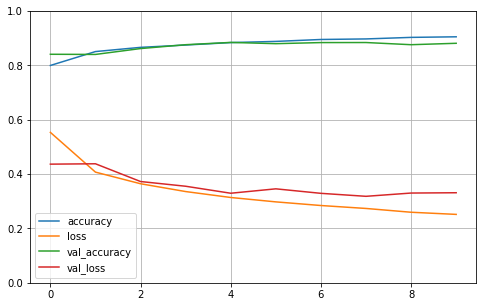

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
# selu缓解梯度消失

In [9]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3634 - accuracy: 0.8738


[0.3633708357810974, 0.8737999796867371]